In [1]:
import pandas as pd

In [2]:
features = pd.read_csv("../data/04_feature/stock_features/price_w_features")

In [3]:
features.loc[:, "date"] = pd.to_datetime(features["date"])

In [4]:
features = features.dropna()

In [6]:
# Define function to reindex each group
def reindex_group(group):
    # Ensure the group is sorted by date
    group = group.sort_values("date")

    # Generate a business day range for this stock ticker
    business_days = pd.date_range(
        start=group["date"].min(), end=group["date"].max(), freq="B"
    )

    # Set the date as the index and reindex to business days
    group = group.set_index("date").reindex(business_days)

    # Reset the index to turn the date back into a column
    group = group.reset_index().rename(columns={"index": "date"})

    return group


# Apply the function using groupby and apply
df = features.groupby("stock_ticker").apply(reindex_group).reset_index(drop=True)

In [7]:
df

,date,stock_ticker,adj_close,close,high,low,open,volume,ftr_high_minus_low,ftr_close_minus_open,ftr_adj_close_mean_7,ftr_adj_close_mean_14,ftr_adj_close_mean_21,ftr_adj_close_std_7,ftr_high_minus_low_shifted_1,ftr_close_minus_open_shifted_1,ftr_adj_close_mean_7_shifted_1,ftr_adj_close_mean_14_shifted_1,ftr_adj_close_mean_21_shifted_1,ftr_adj_close_std_7_shifted_1
0,2014-07-08,A,37.667244,40.879829,41.437767,40.715309,41.373390,2259028.0,0.722458,-0.493561,38.130492,38.239152,38.368061,0.321263,0.286125,-0.057224,38.181149,38.313800,38.422210,0.257715
1,2014-07-09,A,37.502476,40.701000,40.829758,40.429184,40.808296,1787343.0,0.400574,-0.107296,38.073999,38.133947,38.297612,0.395229,0.722458,-0.493561,38.130492,38.239152,38.368061,0.321263
2,2014-07-10,A,37.232239,40.407726,40.507870,40.064377,40.350502,1662641.0,0.443493,0.057224,37.984550,38.039971,38.226506,0.507165,0.400574,-0.107296,38.073999,38.133947,38.297612,0.395229
3,2014-07-11,A,37.304752,40.486408,40.586552,40.164520,40.293278,1654253.0,0.422031,0.193130,37.829196,37.944129,38.158227,0.527616,0.443493,0.057224,37.984550,38.039971,38.226506,0.507165
4,2014-07-14,A,37.449734,40.643776,40.822605,40.500713,40.715309,2079944.0,0.321892,-0.071533,37.713382,37.889642,38.112823,0.505703,0.422031,0.193130,37.829196,37.944129,38.158227,0.527616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109817,2024-05-31,ZTS,169.559998,169.559998,172.149994,167.960007,170.000000,4088400.0,4.189987,-0.440002,170.588573,171.366429,169.996190,0.951288,5.860001,-1.239990,171.050001,171.329286,169.469524,1.134869
1109818,2024-06-03,ZTS,172.369995,172.369995,174.270004,169.979996,170.039993,2142700.0,4.290009,2.330002,170.634286,171.685000,170.240952,1.037043,4.189987,-0.440002,170.588573,171.366429,169.996190,0.951288
1109819,2024-06-04,ZTS,171.880005,171.880005,172.259995,169.660004,170.929993,1304400.0,2.599991,0.950012,170.774288,171.900000,170.470000,1.139939,4.290009,2.330002,170.634286,171.685000,170.240952,1.037043
1109820,2024-06-05,ZTS,175.820007,175.820007,176.729996,172.899994,172.899994,1870800.0,3.830002,2.920013,171.595716,172.081430,170.940000,2.161667,2.599991,0.950012,170.774288,171.900000,170.470000,1.139939


In [10]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
ts_df = TimeSeriesDataFrame.from_data_frame(
    features, id_column="stock_ticker", timestamp_column="date"
)
predictor = TimeSeriesPredictor(
    prediction_length=14,
    path="./test_model",
    target="close",
    eval_metric="MASE",
    freq="B"
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

NameError: name 'train_data' is not defined

In [40]:
predictions.reset_index()

,item_id,timestamp,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,A,2024-06-07,133.693015,131.307696,132.016722,132.536229,133.169890,133.693015,134.246658,134.758894,135.335106,136.300012
1,A,2024-06-10,133.436026,130.397281,131.412794,132.143307,132.821995,133.436026,133.984597,134.719885,135.585289,136.769260
2,A,2024-06-11,133.183913,129.456861,130.694661,131.503991,132.495205,133.183913,134.115114,134.904094,135.839819,137.195433
3,A,2024-06-12,133.149999,129.789748,130.769014,131.810994,132.489904,133.149999,134.142517,135.245859,136.195196,137.360112
4,A,2024-06-13,133.520495,129.244654,130.546914,131.716498,132.659439,133.520495,134.574705,135.728360,136.747658,138.721212
...,...,...,...,...,...,...,...,...,...,...,...,...
6183,ZTS,2024-06-20,175.296207,165.764685,169.001629,171.106110,173.646251,175.296207,177.080926,178.386903,180.481492,183.956142
6184,ZTS,2024-06-21,174.809824,164.495405,168.030973,170.314441,172.508122,174.809824,176.792376,178.371187,180.356732,183.133925
6185,ZTS,2024-06-24,174.299590,164.433567,167.613291,170.430924,172.443988,174.299590,176.395936,178.792220,181.113723,183.637221
6186,ZTS,2024-06-25,174.294141,164.279737,167.762501,169.961232,172.651923,174.294141,176.044252,178.637899,181.185948,184.586228


data with frequency 'None' has been resampled to frequency 'B'.


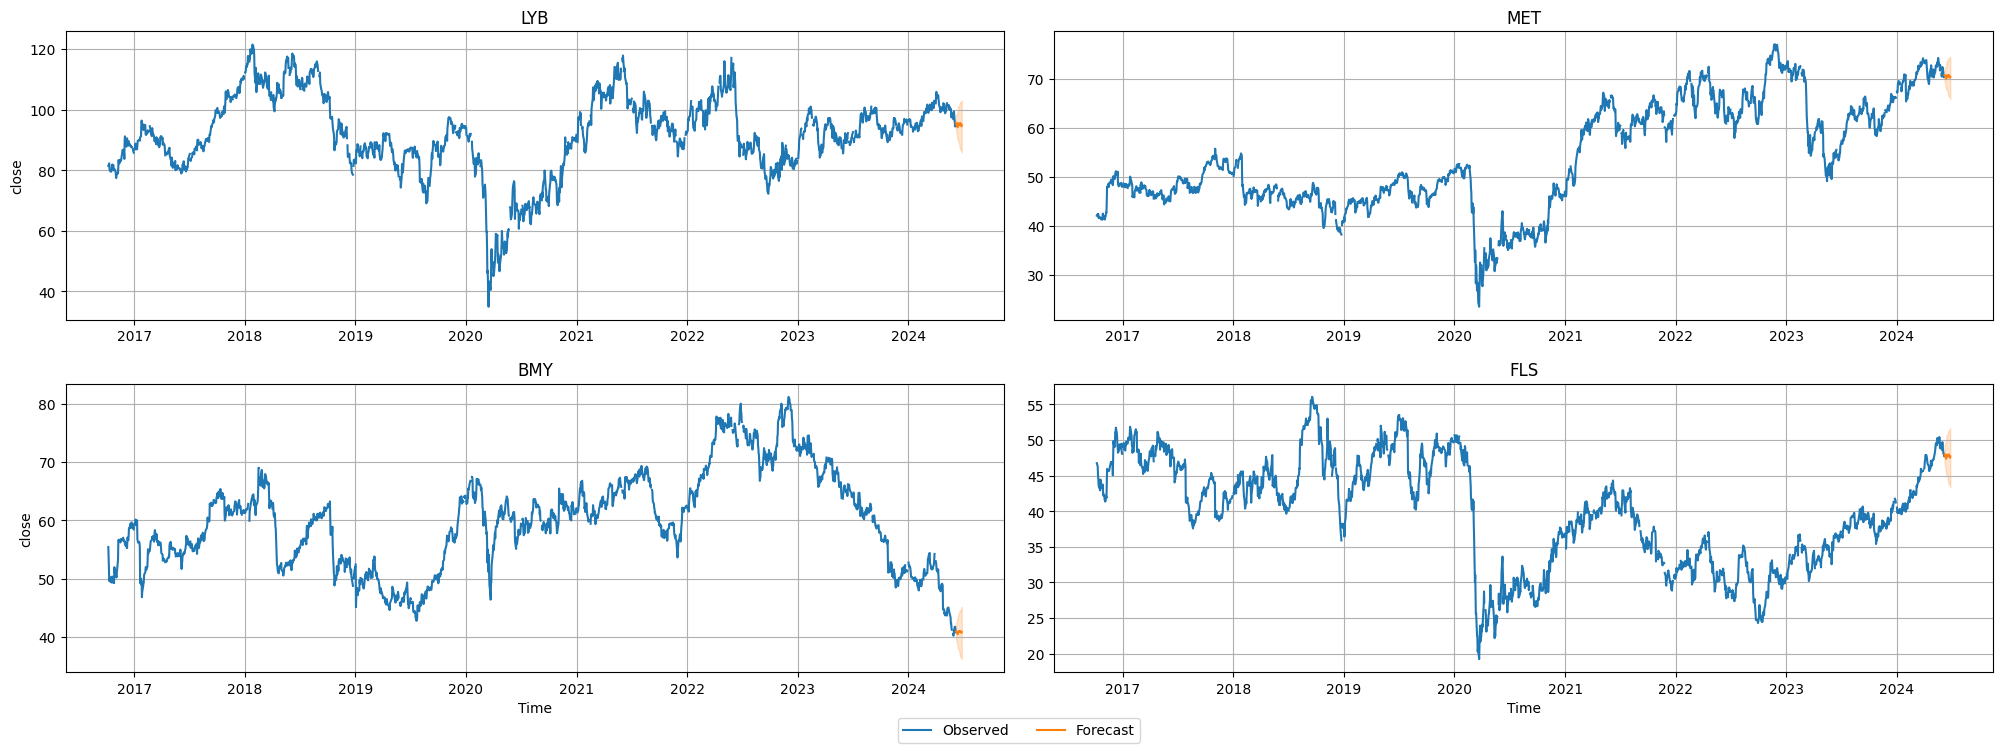

In [52]:
import matplotlib.pyplot as plt

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(
    train_data,
    predictions,
    quantile_levels=[0.1, 0.9],
    max_history_length=2000,
    max_num_item_ids=4,
)

In [11]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize


def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    # Annualize returns and volatility
    returns = np.sum(mean_returns * weights) * 252  # Annualizing the return
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(
        252
    )  # Annualizing the volatility
    sharpe_ratio = (returns - risk_free_rate) / std  # Calculating the Sharpe Ratio
    return returns, std, sharpe_ratio


def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    _, _, sharpe_ratio = portfolio_performance(
        weights, mean_returns, cov_matrix, risk_free_rate
    )
    return -sharpe_ratio


def get_constraints():
    return {"type": "eq", "fun": lambda x: np.sum(x) - 1}


def get_bounds(num_assets):
    return tuple((0, 1) for asset in range(num_assets))


num_assets = len(returns.columns)
initial_guess = num_assets * [
    1.0 / num_assets,
]

mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0  # Adjust as needed

result = minimize(
    negative_sharpe_ratio,
    initial_guess,
    args=(mean_returns, cov_matrix, risk_free_rate),
    method="SLSQP",
    bounds=get_bounds(num_assets),
    constraints=get_constraints(),
)

optimal_weights = result.x

portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_performance(
    optimal_weights, mean_returns, cov_matrix, risk_free_rate
)

print("Optimal Weights: ", optimal_weights)
print("Expected Portfolio Return: ", portfolio_return)
print("Expected Portfolio Volatility: ", portfolio_volatility)
print("Sharpe Ratio: ", portfolio_sharpe)

Optimal Weights:  [0.40223445 0.59776555]
Expected Portfolio Return:  0.13563560654558243
Expected Portfolio Volatility:  0.22708966719750132
Sharpe Ratio:  0.5972777547276922
